In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, classification_report
import warnings

In [3]:
# Suppress specific XGBoost warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Load the processed dataset
file_path = 'model_data.csv'  # Update this with your local file path
original_data = pd.read_csv(file_path)

# Create a copy of the original data for processing
data = original_data.copy()

# Create the target variable based on shot_outcome
data['shot_outcome'] = data['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)

# Drop the columns that are not needed for the model
data = data.drop(columns=['location', 'goalkeeper_location', 'statsbomb_xg', 'possession_team', 'player'])

# Handle categorical variables including 'position'
data = pd.get_dummies(data, drop_first=True)

# Define the features and target variable
X = data.drop(columns=['shot_outcome'])
y = data['shot_outcome']

# Split the dataset into training (60%) and testing (40%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Scale the features using Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model with the best parameters from previous output
best_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0,
    'min_child_weight': 1,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# Initialize the XGBoost model with best parameters
xgb_model = XGBClassifier(**best_params)

# Fit the model
xgb_model.fit(X_train_scaled, y_train)

# Predict the xG values for the entire dataset (including the training set)
X_scaled = scaler.transform(X)
calculated_xg = xgb_model.predict_proba(X_scaled)[:, 1]
calculated_xg = calculated_xg.round(7)

# Add the calculated xG values back to the original dataframe
original_data['AJS_xg'] = calculated_xg

# Save the dataset with calculated xG values back to the same file
output_file_path = 'model_data_with_calculated_xg.csv'
original_data.to_csv(output_file_path, index=False)

# Evaluate the model
y_pred_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]
log_loss_score = log_loss(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
y_pred = xgb_model.predict(X_test_scaled)
report = classification_report(y_test, y_pred)

# Display the evaluation metrics
print(f'Log Loss: {log_loss_score}')
print(f'ROC AUC Score: {roc_auc}')
print('Classification Report:')
print(report)



Log Loss: 0.225563369164342
ROC AUC Score: 0.8831712962962963
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       600
           1       0.77      0.38      0.50        72

    accuracy                           0.92       672
   macro avg       0.85      0.68      0.73       672
weighted avg       0.91      0.92      0.91       672



,possession_team,player,position,location,distance_to_goal,angle_to_goal,shot_speed,play_pattern,minute,shot_body_part,shot_one_on_one,shot_first_time,shot_outcome,goalkeeper_location,goalkeeper_distance,shot_pressure,statsbomb_xg,AJS_xg
0,Morocco Women's,Ibtissam Jraïdi,Forward,"[115.6, 23.1]",17.75387,6.09144,37.28771,Regular Play,0,Foot,True,False,Saved,"[118.2, 35.9]",13.06139,1,0.011643,0.040694
1,Colombia Women's,Mayra Tatiana Ramírez Ramírez,Forward,"[113.6, 54.5]",15.57562,11.55180,22.60042,Regular Play,10,Foot,False,True,Off T,"[118.9, 44.5]",11.31769,2,0.017579,0.169113
2,Morocco Women's,Ibtissam Jraïdi,Forward,"[107.8, 33.7]",13.87083,26.51428,11.62217,Regular Play,12,Head,False,False,Saved,"[118.1, 37.9]",11.12340,2,0.062036,0.234132
3,Colombia Women's,María Catalina Usme Pineda,Midfielder,"[103.2, 74.4]",38.01381,4.90953,18.59899,From Free Kick,16,Foot,False,False,Off T,"[119.0, 40.4]",37.49187,0,0.005588,0.111857
4,Colombia Women's,Daniela Montoya Quiróz,Midfielder,"[111.0, 39.3]",9.05539,43.83945,429.42998,From Throw In,19,Head,False,False,Saved,"[112.2, 39.6]",1.23693,1,0.169690,0.108679
5,Colombia Women's,Mayra Tatiana Ramírez Ramírez,Forward,"[96.7, 45.2]",23.80966,17.12608,261.42628,From Throw In,24,Foot,False,False,Blocked,"[119.2, 40.9]",22.90720,3,0.037222,0.006240
6,Morocco Women's,Anissa Lahmari,Midfielder,"[96.7, 43.4]",23.50532,17.55576,17.52586,Regular Play,30,Foot,False,False,Off T,"[118.6, 40.9]",22.04223,2,0.040333,0.040889
7,Colombia Women's,Leicy Maria Santos Herrera,Forward,"[108.9, 36.3]",11.79873,32.85472,9.63614,Regular Play,43,Head,False,False,Off T,"[118.6, 39.7]",10.27862,3,0.120509,0.084488
8,Colombia Women's,Leicy Maria Santos Herrera,Forward,"[94.8, 40.4]",25.20020,16.52724,417.85140,Regular Play,45,Foot,False,True,Blocked,"[118.8, 40.1]",24.00187,3,0.034365,0.002169
9,Morocco Women's,Ghizlane Chebbak,Midfielder,"[108.1, 40.1]",11.90168,34.18362,24.40945,Penalty,48,Foot,False,False,Saved,"[120, 40.3]",11.90168,0,0.783500,0.562203


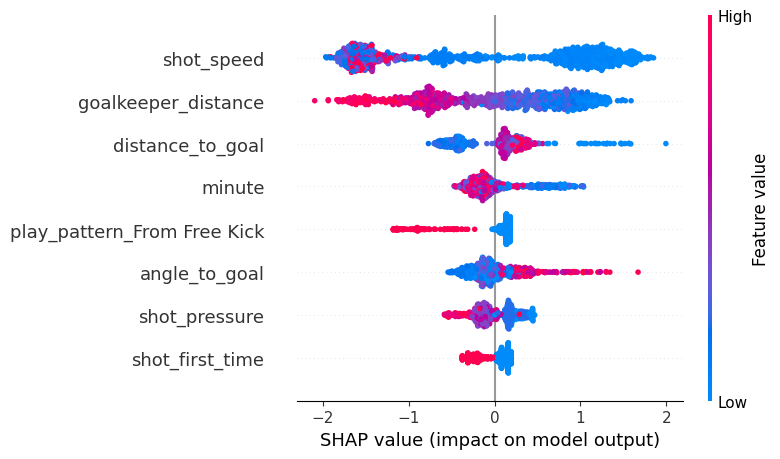

    possession_team                         player    position       location  \
0   Morocco Women's                Ibtissam Jraïdi     Forward  [115.6, 23.1]   
1  Colombia Women's  Mayra Tatiana Ramírez Ramírez     Forward  [113.6, 54.5]   
2   Morocco Women's                Ibtissam Jraïdi     Forward  [107.8, 33.7]   
3  Colombia Women's     María Catalina Usme Pineda  Midfielder  [103.2, 74.4]   
4  Colombia Women's         Daniela Montoya Quiróz  Midfielder  [111.0, 39.3]   

   distance_to_goal  angle_to_goal  shot_speed    play_pattern  minute  \
0          17.75387        6.09144    37.28771    Regular Play       0   
1          15.57562       11.55180    22.60042    Regular Play      10   
2          13.87083       26.51428    11.62217    Regular Play      12   
3          38.01381        4.90953    18.59899  From Free Kick      16   
4           9.05539       43.83945   429.42998   From Throw In      19   

  shot_body_part  shot_one_on_one  shot_first_time shot_outcome  \
0

In [4]:
import shap

# SHAP value analysis
explainer = shap.Explainer(xgb_model, X_train_scaled)
shap_values = explainer(X_train_scaled)

# Plot the SHAP summary with only the top 8 features
shap.summary_plot(shap_values, X_train, feature_names=X.columns.tolist(), max_display=8)

# Display the first few rows of the dataframe with calculated xG values
print(original_data.head())


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, roc_auc_score, classification_report
import warnings
import numpy as np

# Suppress specific XGBoost warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Load the processed dataset
file_path = 'model_data.csv'  # Update this with your local file path
original_data = pd.read_csv(file_path)

# Create a copy of the original data for processing
data = original_data.copy()

# Create the target variable based on shot_outcome
data['shot_outcome'] = data['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)

# Drop the columns that are not needed for the model
data = data.drop(columns=['location', 'goalkeeper_location', 'statsbomb_xg', 'possession_team', 'player'])

# Handle categorical variables including 'position'
data = pd.get_dummies(data, drop_first=True)

# Define the features and target variable
X = data.drop(columns=['shot_outcome'])
y = data['shot_outcome']

# Split the dataset into training (60%) and testing (40%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Scale the features using Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model with the best parameters from previous output
best_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0,
    'min_child_weight': 1,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# Initialize the XGBoost model with best parameters
xgb_model = XGBClassifier(**best_params)

# Fit the model
xgb_model.fit(X_train_scaled, y_train)

# Predict the xG values for the entire dataset (including the training set)
X_scaled = scaler.transform(X)
calculated_xg = xgb_model.predict_proba(X_scaled)[:, 1]
calculated_xg = calculated_xg.round(7)

# Add the calculated xG values back to the original dataframe
original_data['AJS_xg'] = calculated_xg

# Save the dataset with calculated xG values back to the same file
output_file_path = 'model_data_with_calculated_xg.csv'
original_data.to_csv(output_file_path, index=False)

# Function to evaluate and return metrics
def evaluate_model(model, X, y, dataset_type="Testing"):
    y_pred_prob = model.predict_proba(X)[:, 1]
    log_loss_score = log_loss(y, y_pred_prob)
    roc_auc = roc_auc_score(y, y_pred_prob)
    y_pred = model.predict(X)
    report = classification_report(y, y_pred, output_dict=True)
    
    # Extract precision, recall, and f1-score for the positive class (label=1)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1_score = report['1']['f1-score']
    
    return [dataset_type, log_loss_score, roc_auc, precision, recall, f1_score]

# Evaluate on Training data
training_results = evaluate_model(xgb_model, X_train_scaled, y_train, dataset_type="Training")

# Evaluate on Testing data
testing_results = evaluate_model(xgb_model, X_test_scaled, y_test, dataset_type="Testing")

# Combine results into a DataFrame
results_df = pd.DataFrame([training_results, testing_results],
                          columns=["Dataset", "Log Loss", "ROC AUC", "Precision", "Recall", "F1-Score"])

# Display the results in a tabular format
print(results_df)


    Dataset  Log Loss   ROC AUC  Precision    Recall  F1-Score
0  Training  0.141626  0.982113   0.963636  0.473214  0.634731
1   Testing  0.225563  0.883171   0.771429  0.375000  0.504673
